In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/Hikari_train_2labels.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/Hikari_test_2labels.pkl')

In [5]:
train_df = train_df.reset_index(drop=True)
train_df

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,0.0,0.0,0.0,0.0,0.0,29200,65535,74,False,True
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,True
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,True
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,True
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,0.0,0.0,0.0,0.0,0.0,29200,65535,60,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288401,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,True
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,0.0,0.0,0.0,0.0,0.0,29200,65160,402,False,True
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0,0,0,False,True
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,0.0,0.0,0.0,0.0,0.0,29200,65160,402,False,True


In [6]:
test_df = test_df.reset_index(drop=True)
test_df

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,True,False
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,5.999647e+07,5.999737e+07,1.199938e+08,5.999692e+07,633.720014,0,0,0,False,True
111054,0.230230,10,13,3,8,43.434853,56.465310,99.900163,1.300000,328,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,True,False


In [7]:
train_normal_data = train_df[train_df['is_Normal'] == True]
train_normal_data = train_normal_data.drop('is_Attack', axis=1)
train_normal_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,74,True
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,60,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288401,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True


In [8]:
train_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/train_normal.pkl")

In [9]:
X_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/train_normal.pkl")
X_train

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,74,True
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,60,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288401,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True


In [10]:
X_train = X_train.drop('is_Normal', axis=1)
X_train

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,3.492634e+06,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,74
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,2.460194e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,2.612996e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,2.582002e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,1.179462e+06,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288401,1.000000,8,...,1.521111e+02,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,3.013411e+05,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,2.688599e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,2.847521e+05,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402


In [11]:
test_normal_data = test_df[test_df['is_Normal'] == True]
test_normal_data = test_normal_data.drop('is_Attack', axis=1)
test_normal_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
5,0.319120,9,12,3,7,28.202563,37.603418,65.805981,1.333333,296,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111050,0.000076,1,1,0,0,13189.635220,13189.635220,26379.270440,1.000000,40,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200,True
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,0.0,5.999647e+07,5.999737e+07,1.199938e+08,5.999692e+07,633.720014,0,0,0,True


In [12]:
test_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_normal.pkl")

In [13]:
X_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_normal.pkl")
X_test

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
5,0.319120,9,12,3,7,28.202563,37.603418,65.805981,1.333333,296,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111050,0.000076,1,1,0,0,13189.635220,13189.635220,26379.270440,1.000000,40,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200,True
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,0.0,5.999647e+07,5.999737e+07,1.199938e+08,5.999692e+07,633.720014,0,0,0,True


In [14]:
X_test = X_test.drop('is_Normal', axis=1)
X_test

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,26566.982269,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,33776.998520,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,23761.987686,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0
5,0.319120,9,12,3,7,28.202563,37.603418,65.805981,1.333333,296,...,319119.930267,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111050,0.000076,1,1,0,0,13189.635220,13189.635220,26379.270440,1.000000,40,...,75.817108,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,0,29200
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,27677.059174,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,23514.032364,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,0.000000,0.0,5.999647e+07,5.999737e+07,1.199938e+08,5.999692e+07,633.720014,0,0,0


In [15]:
# Encode labels and scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
X_train.shape

torch.Size([414066, 79])

In [16]:
X_test.shape

torch.Size([103516, 79])

In [17]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(79, 145),
            nn.ReLU(),
            nn.Linear(145, 111),
            nn.ReLU(),
            nn.Linear(111, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 79),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
# Initialize the autoencoder
model = AE().to(device)

# Loss function and optimizer
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00377098853279706)
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=79, out_features=145, bias=True)
    (1): ReLU()
    (2): Linear(in_features=145, out_features=111, bias=True)
    (3): ReLU()
    (4): Linear(in_features=111, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=79, bias=True)
    (5): Sigmoid()
  )
)


In [19]:
# Convert the data to DataLoader
# train_loader = DataLoader(X_train, batch_size=len(X_train), shuffle=True)
# test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=True)

AUTOENCODER RECONSTRUCTION LOSS

Epoch 50/1000, Train Loss: 0.01034168154001236
Epoch 100/1000, Train Loss: 0.007373324129730463
Epoch 150/1000, Train Loss: 0.007232876494526863
Epoch 200/1000, Train Loss: 0.007141140755265951
Epoch 250/1000, Train Loss: 0.006885338108986616
Epoch 300/1000, Train Loss: 0.006855172570794821
Epoch 350/1000, Train Loss: 0.006783775519579649
Epoch 400/1000, Train Loss: 0.006784981582313776
Epoch 450/1000, Train Loss: 0.006754460744559765
Epoch 500/1000, Train Loss: 0.006744582671672106
Epoch 550/1000, Train Loss: 0.006750096101313829
Epoch 600/1000, Train Loss: 0.006739799864590168
Epoch 650/1000, Train Loss: 0.0067369150929152966
Epoch 700/1000, Train Loss: 0.006733236834406853
Epoch 750/1000, Train Loss: 0.006724943406879902
Epoch 800/1000, Train Loss: 0.006717747543007135
Epoch 850/1000, Train Loss: 0.006707161199301481
Epoch 900/1000, Train Loss: 0.00669995229691267
Epoch 950/1000, Train Loss: 0.006693142466247082
Epoch 1000/1000, Train Loss: 0.0066932

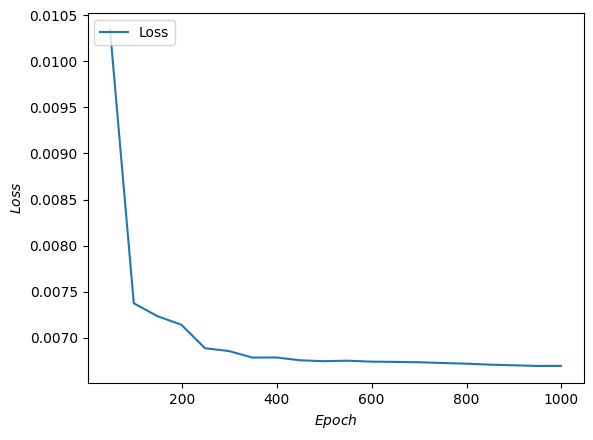

In [20]:
# Training the Autoencoder
model.train()

x_axis = []
y_axis = []

outputs = []
epochs = 1000

print("AUTOENCODER RECONSTRUCTION LOSS\n")
for epoch in range(epochs):
  # for idx, data in enumerate(train_loader):
    # x_train = data[0].to(device)

    optimizer.zero_grad()
    pred = model(X_train).to(device)
    loss = criterion(pred, X_train).to(device)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
      x_axis.append(epoch)
      y_axis.append(loss.item())
      print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}')

fig, x1 = plt.subplots()
x1.set_xlabel('$Epoch$')
x1.set_ylabel('$Loss$')
x1.plot(x_axis, y_axis, label="Loss")
x1.legend(loc='upper left')
plt.show()

In [21]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/ModelSaving/AE_HIKARI.pth")

In [22]:
new_model = AE().to(device)

In [23]:
new_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/ModelSaving/AE_HIKARI.pth"))

<ipython-input-23-594acaea13ce>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKAR

<All keys matched successfully>

In [24]:
# Evaluate the Autoencoder on Test Data

model.eval()

with torch.no_grad():
  n = len(X_test)
  print("Size of n: ", len(X_test))
  reconstructed = new_model(X_test).to(device)
  # normal_loss = torch.sum((X_test - reconstructed) ** 2, dim=1)
  normal_loss = (torch.sum((X_test - reconstructed) ** 2, dim=1)) / len(X_test)

normal_loss_np = normal_loss.cpu().numpy()  # Convert to numpy array
normal_loss_np = normal_loss_np.reshape(-1)
# print("AUTOENCODER RECONSTRUCTION LOSS\n")
# print(f'Test Loss: {loss.item():}')
print("Reconstruction normal error: ", normal_loss_np)
print("Reconstruction normal error percentile: ", np.percentile(normal_loss_np, [0, 25, 50, 75, 90, 95, 99]))
print("Size of normal loss: ", normal_loss_np.size)

Size of n:  103516
Reconstruction normal error:  [4.5522887e-07 3.7757883e-07 3.1732489e-07 ... 3.0826698e-07 1.7904336e-05
 4.4998728e-06]
Reconstruction normal error percentile:  [1.95467393e-08 3.11355869e-07 9.88697479e-07 1.20361385e-05
 1.24964536e-05 1.50604681e-05 3.03193178e-05]
Size of normal loss:  103516


In [25]:
print(format(np.percentile(normal_loss_np, [99])))

[3.03193178e-05]


In [26]:
# Load the attack data
test_attack_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/Hikari_test_2labels.pkl')
test_attack_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,True,False
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,False,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,5.999647e+07,5.999737e+07,1.199938e+08,5.999692e+07,633.720014,0,0,0,False,True
111054,0.230230,10,13,3,8,43.434853,56.465310,99.900163,1.300000,328,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,29200,65160,402,True,False


In [27]:
test_attack_data = test_df[test_df['is_Attack'] == True]
test_attack_data = test_attack_data.drop('is_Normal', axis=1)
test_attack_data = test_attack_data.reset_index(drop=True)

In [28]:
test_attack_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_attack.pkl")

In [29]:
X_test_attack = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_attack.pkl")
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402,True
1,7.153523,13,13,6,4,1.817286,1.817286,3.634573,1.000000,412,...,302313.612397,6.670371e+06,6.670371e+06,6.670371e+06,6.670371e+06,0.0,29200,65160,0,True
2,2.238758,15,14,6,6,6.700144,6.253468,12.953612,0.933333,488,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,True
3,6.730588,15,14,6,6,2.228631,2.080056,4.308687,0.933333,488,...,150620.023936,6.461417e+06,6.461417e+06,6.461417e+06,6.461417e+06,0.0,29200,65160,0,True
4,11.532148,15,14,6,6,1.300712,1.213998,2.514709,0.933333,464,...,284843.743689,1.107336e+07,1.107336e+07,1.107336e+07,1.107336e+07,0.0,29200,65160,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,4.099786,43,38,9,31,10.488352,9.268776,19.757129,0.883721,1528,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0,True
7536,0.356221,9,12,3,7,25.265217,33.686956,58.952174,1.333333,296,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402,True
7537,0.271308,10,13,3,8,36.858486,47.916031,84.774517,1.300000,328,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402,True
7538,7.018991,23,16,6,12,3.276824,2.279530,5.556354,0.695652,756,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0,True


In [30]:
X_test_attack = X_test_attack.drop('is_Attack', axis=1)
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,3.570340e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402
1,7.153523,13,13,6,4,1.817286,1.817286,3.634573,1.000000,412,...,2.415760e+05,302313.612397,6.670371e+06,6.670371e+06,6.670371e+06,6.670371e+06,0.0,29200,65160,0
2,2.238758,15,14,6,6,6.700144,6.253468,12.953612,0.933333,488,...,2.238776e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0
3,6.730588,15,14,6,6,2.228631,2.080056,4.308687,0.933333,488,...,1.345966e+05,150620.023936,6.461417e+06,6.461417e+06,6.461417e+06,6.461417e+06,0.0,29200,65160,0
4,11.532148,15,14,6,6,1.300712,1.213998,2.514709,0.933333,464,...,2.294010e+05,284843.743689,1.107336e+07,1.107336e+07,1.107336e+07,1.107336e+07,0.0,29200,65160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,4.099786,43,38,9,31,10.488352,9.268776,19.757129,0.883721,1528,...,4.099814e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0
7536,0.356221,9,12,3,7,25.265217,33.686956,58.952174,1.333333,296,...,3.562210e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402
7537,0.271308,10,13,3,8,36.858486,47.916031,84.774517,1.300000,328,...,2.713079e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402
7538,7.018991,23,16,6,12,3.276824,2.279530,5.556354,0.695652,756,...,7.047733e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0


In [31]:
# Scale the anomalous data
X_test_attack = scaler.transform(X_test_attack)

# Convert to PyTorch tensors
X_test_attack = torch.tensor(X_test_attack, dtype=torch.float).to(device)

In [32]:
# Compute Reconstruction Errors for anomaly Data

with torch.no_grad():
  # n = len(X_test_attack)
  reconstructed_attack = new_model(X_test_attack).to(device)
  # attack_loss = torch.sum((X_test_attack - reconstructed_attack) ** 2, dim=1)
  attack_loss = (torch.sum((X_test_attack - reconstructed_attack) ** 2, dim=1)) / len(X_test_attack)

attack_loss_np = attack_loss.cpu().numpy()  # Convert to numpy array
attack_loss_np = attack_loss_np.reshape(-1)
print("Reconstruction attack error: ", attack_loss_np)
print("Reconstruction attack error percentile: ", np.percentile(attack_loss.cpu(), [0, 25, 50, 75, 90, 95, 99]))
print("Size of attack loss: ", attack_loss_np.size)

Reconstruction attack error:  [1.7234270e-04 1.6683871e-04 1.6668203e-04 ... 1.6691805e-04 6.1892140e-05
 1.6691032e-04]
Reconstruction attack error percentile:  [8.54353686e-07 1.65571750e-04 1.67820610e-04 1.70390314e-04
 1.74053074e-04 1.77159692e-04 3.11517697e-04]
Size of attack loss:  7540


In [33]:
print(format(np.percentile(attack_loss_np, [99])))

[0.00031152]


In [34]:
# # Compute Reconstruction Errors for Normal Data (Test Data)

# with torch.no_grad():
#   reconstructed_normal = new_model(X_test).to(device)
#   normal_loss = torch.sum((X_test - reconstructed_normal) ** 2, dim=1)
# normal_loss_np = normal_loss.cpu().numpy()  # Convert to numpy array
# normal_loss_np = normal_loss_np.reshape(-1)
# print("Reconstruction normal error: ", np.percentile(normal_loss_np, [0, 25, 50, 75, 90, 95, 99]))
# print("Reconstruction normal error: ", normal_loss_np)
# print("Size of normal loss: ", normal_loss_np.size)

In [35]:
# print(format(3.11301911e+00))

Text(0.5, 0, 'Index')

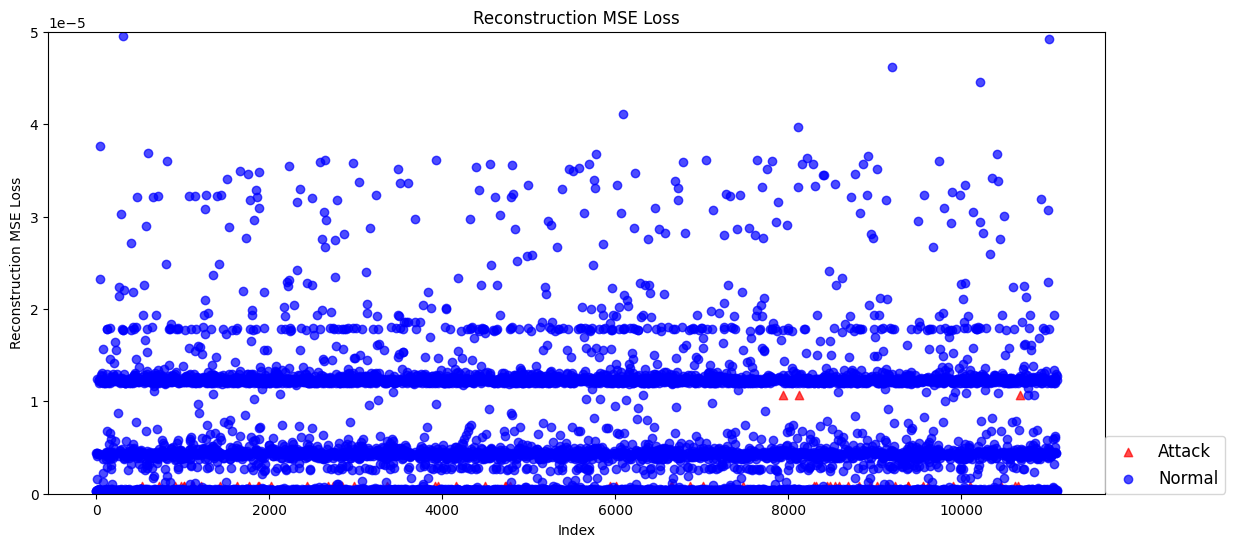

In [36]:
loss_df = pd.DataFrame()
loss_df['Class'] = [0] * len(normal_loss_np) + [1] * len(attack_loss_np)
loss_df['MSELoss'] = np.hstack([normal_loss_np, attack_loss_np])
loss_df = loss_df.sample(frac=0.1).reset_index(drop=True)

markers = ['o', '^']
markers = ['o', '^']
colors = ['blue', 'red']
labels = ['Normal', 'Attack']

plt.figure(figsize=(30, 6))
plt.subplot(121)
for flag in [1, 0]:
    temp = loss_df[loss_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MSELoss'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.ylim(0, 0.00005)
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE Loss')
plt.ylabel('Reconstruction MSE Loss')
plt.xlabel('Index')

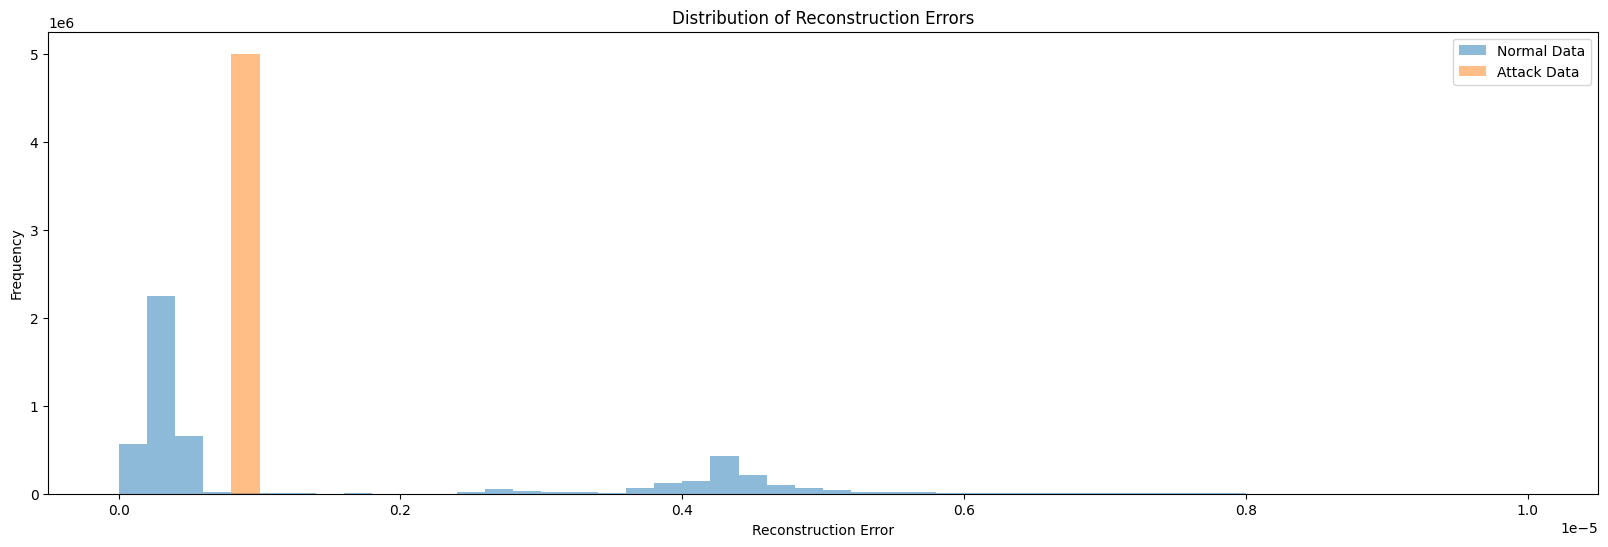

Threshold at 90th percentile: 1.2496453564381227e-05
Threshold at 95th percentile: 1.5060468058436527e-05
Threshold at 99th percentile: 3.0319317829707972e-05
Mean Reconstruction Error for Normal Data: 5.120844889461296e-06
Standard Deviation for Normal Data: 6.6611787588044535e-06


In [42]:
# Plotting histograms of reconstruction errors
plt.figure(figsize=(20, 6))
plt.hist(normal_loss_np, bins=50, alpha=0.5, range=[0, 0.00001], histtype='stepfilled', density=True, label='Normal Data')
plt.hist(attack_loss_np, bins=50, alpha=0.5, range=[0, 0.00001], histtype='stepfilled', density=True, label='Attack Data')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

# Using Percentiles to determine threshold
percentiles = [90, 95, 99]
for p in percentiles:
    threshold = np.percentile(normal_loss_np, p)
    print(f"Threshold at {p}th percentile: {threshold:}")

# Additional statistical analysis (Optional)
mean_normal = np.mean(normal_loss_np)
std_normal = np.std(normal_loss_np)
print(f"Mean Reconstruction Error for Normal Data: {mean_normal:}")
print(f"Standard Deviation for Normal Data: {std_normal:}")

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the threshold as the 95th percentile of normal reconstruction errors
threshold = np.percentile(normal_loss_np, 99) #Threshold for classification
print("threshold:", threshold)

# Classify as attack if reconstruction error exceeds the threshold

# y_pred_test = torch.sum((X_test - reconstructed_normal) ** 2, axis=1) > threshold
# y_pred_anomalous = torch.sum((X_test_attack - reconstructed_attack) ** 2, axis=1) > threshold
# y_pred_test = (X_test-reconstructed).pow(2).sum(1) > threshold
# y_pred_anomalous = (X_test_attack - reconstructed_attack).pow(2).sum(1) > threshold
y_pred_test = (torch.sum((X_test - reconstructed) ** 2, dim=1) / len(X_test)) > threshold
y_pred_anomalous = (torch.sum((X_test_attack - reconstructed_attack), dim=1) / len(X_test_attack)) > threshold

y_pred_test = y_pred_test.cpu()
y_pred_anomalous = y_pred_anomalous.cpu()

# True labels: 0 for normal, 1 for attack
y_true_test = np.zeros(len(y_pred_test))
y_true_anomalous = np.ones(len(y_pred_anomalous))

# Combine predictions and true labels
y_pred_combined = np.concatenate([y_pred_test.numpy(), y_pred_anomalous.numpy()])
y_true_combined = np.concatenate([y_true_test, y_true_anomalous])

# Calculate accuracy
accuracy = accuracy_score(y_true_combined, y_pred_combined)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


threshold: 3.0319317829707972e-05
Accuracy: 0.9849
Confusion Matrix:
[[102480   1036]
 [   639   6901]]


In [39]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Attack']
print(classification_report(y_true_combined, y_pred_combined, target_names=target_names, digits=4))
print(confusion_matrix(y_true_combined, y_pred_combined))

              precision    recall  f1-score   support

      Normal     0.9938    0.9900    0.9919    103516
      Attack     0.8695    0.9153    0.8918      7540

    accuracy                         0.9849    111056
   macro avg     0.9316    0.9526    0.9418    111056
weighted avg     0.9854    0.9849    0.9851    111056

[[102480   1036]
 [   639   6901]]
